# Retraining MobileNet V2 for Person Detection and ESP32 Compatibility


In [15]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mat
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,confusion_matrix
import sklearn as skl
import pandas as pd
import seaborn as sns
import cv2

In [16]:
print("TensorFlow version:", tf.__version__)
print("TensorFlow Datasets version:", tfds.__version__)
print("Keras version:", keras.__version__)
print("NumPy version:", np.__version__)
print("Matplotlib version:", mat.__version__)
print("Scikit-learn version:", skl.__version__)
print("Pandas version:", pd.__version__)
print("Seaborn version:", sns.__version__)
print("OpenCV version:", cv2.__version__)

TensorFlow version: 2.17.0
TensorFlow Datasets version: 4.9.7
Keras version: 3.4.1
NumPy version: 1.26.4
Matplotlib version: 3.7.5
Scikit-learn version: 1.5.2
Pandas version: 2.2.3
Seaborn version: 0.13.2
OpenCV version: 4.11.0


In [17]:
# constants for various parts of the model
IMAGE_CHANNELS = 3

# input image (ie image from esp 32 looks size)
IMAGE_HEIGHT = 600
IMAGE_WIDTH = 800
IMAGE_SHAPE = (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)

# pretrained MobileNetV2 model image size
BASE_MODEL_IMAGE_HEIGHT = 96
BASE_MODEL_IMAGE_WIDTH = 96
BASE_MODEL_IMAGE_SHAPE = (BASE_MODEL_IMAGE_HEIGHT, BASE_MODEL_IMAGE_WIDTH, IMAGE_CHANNELS)

# final model input shape (flat)
MODEL_INPUT_SHAPE = (IMAGE_CHANNELS * IMAGE_HEIGHT * IMAGE_WIDTH)

BATCH_SIZE = 32

MODEL_SAVE_PATH = './model.keras'
LITE_MODEL_SAVE_PATH = './model.tflite'


## Preparing a Dataset

### Using an Existing Dataset

In [18]:
# Data set file location
#data_dir = 'G:\ml_datasets\coco'

# Load the dataset with the specified data directory ~25GB
ds_train, ds_validation = tfds.load('coco/2017', split=['train','validation'])

# Define the label for 'person' in the dataset
# The original label is a list of objects classes with bounding boxes
# The label for 'person' in the COCO dataset is 0 there are 80 classes in the COCO dataset
# we will create a new label that is 1 if the object is a person and 0 otherwise

COCO_PERSON_CLASS = 0 
def create_label(example):
    objects = example['objects']['label']
    person_present = tf.reduce_any(tf.equal(objects, COCO_PERSON_CLASS))
    example['person_present'] = tf.reshape(person_present, (1,1))
    output = {'image': example['image'], 'label': 1 if example['person_present'] else 0}
    output['label'] = tf.reshape(output['label'], (1,1))
    return output

def format_image(example):
    # Resize the image
    example["image"] = tf.image.resize(example["image"], [IMAGE_HEIGHT, IMAGE_WIDTH])
    # convert the pixel values to be between 0 and 1
    example["image"] = tf.cast(example["image"], tf.float32) / 255.0
    return example

# flatten image (flat image match the shape of images from the esp32 camera)
def flatten_image(example):
    example["image"] = tf.reshape(example["image"], (1,IMAGE_CHANNELS * IMAGE_HEIGHT * IMAGE_WIDTH,))
    return example
    
# tuple format (Training expects a tuple of (image, label))
def convert_to_tuple(example):
    return (example["image"], example["label"])

# Apply the mapping functions to the dataset
ds_train = ds_train.map(create_label)
ds_validation = ds_validation.map(create_label)
ds_train = ds_train.map(format_image)
ds_validation = ds_validation.map(format_image)
ds_train = ds_train.map(flatten_image)
ds_validation = ds_validation.map(flatten_image)
ds_train = ds_train.map(convert_to_tuple)
ds_validation = ds_validation.map(convert_to_tuple)


(1, 1440000)
(1, 1)
Person present: [[1]]


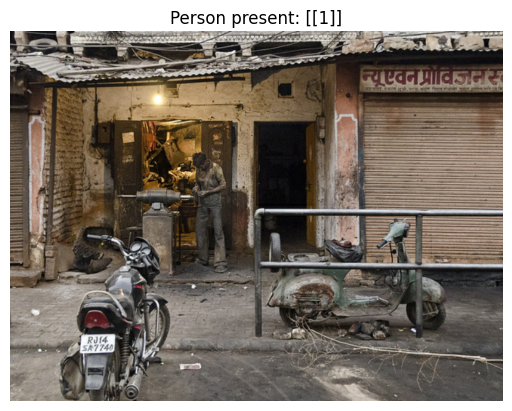

2025-03-21 16:42:43.356028: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [19]:

# Iterate through the dataset and print an example
for example in ds_train.take(1):
    image, person_present = example[0], example[1]
    print(image.shape)
    print(person_present.shape)
    print(f"Person present: {person_present.numpy()}")
    
    # Display the image using Matplotlib
    plt.imshow(tf.reshape(image, (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)))
    plt.title(f"Person present: {person_present}")
    plt.axis('off')
    plt.show()



In [20]:
#TODO using a batched dataset breaks training?
ds_train_batched = ds_train.shuffle(1024).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
for example in ds_train_batched.take(1):
    print(example[0].shape)
    print(example[1].shape)
print(ds_train_batched)

(32, 1, 1440000)
(32, 1, 1)
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 1, 1440000), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1, 1), dtype=tf.int32, name=None))>


### Creating Your Own Dataset

In [21]:
# Define the preprocessing functions
def load_and_preprocess_image(path):
    image_string = tf.io.read_file(path)
    img = tf.io.decode_jpeg(image_string, channels=3)
    return tf.reshape(tf.image.resize(img, [IMAGE_HEIGHT,IMAGE_WIDTH ]) /255, (1,IMAGE_CHANNELS * IMAGE_HEIGHT * IMAGE_WIDTH,))

def load_and_preprocess_from_path_labels(path, label):
    label = tf.reshape( label,(1,1))
    return load_and_preprocess_image(path), label

def create_dataset (label_studio_csv, path_to_image_upload_folder, train_val_split = 0.8):
    # Load the CSV file into a DataFrame
    df = pd.read_csv(label_studio_csv)

    # Extract image paths and labels
    all_image_paths = df['image'].apply(lambda x: x.replace('/data', path_to_image_upload_folder)).tolist()
    all_image_labels = df['choice'].apply(lambda x: 1 if x == 'person' else 0 ).tolist()
    ds = tf.data.Dataset.from_tensor_slices((all_image_paths, all_image_labels))
    csv_dataset = ds.map(load_and_preprocess_from_path_labels, num_parallel_calls=tf.data.AUTOTUNE)
    # Set the seed for reproducibility

    # Shuffle the dataset
    csv_dataset = csv_dataset.shuffle(buffer_size=len(all_image_paths), seed=42, reshuffle_each_iteration=False)
    # Determine the split sizes
    dataset_size = len(all_image_paths)
    train_size = int(train_val_split * dataset_size)
    train_csv_dataset = csv_dataset.take(train_size)
    val_csv_dataset = csv_dataset.skip(train_size)
    return train_csv_dataset, val_csv_dataset

# make the data set have equal number of each class
def balance_data_set (ds):

    # Separate the training dataset into two datasets based on labels
    dataset_true = ds.filter(lambda image, label: tf.equal(tf.reshape(label, ()), 1))
    dataset_false = ds.filter(lambda image, label: not tf.equal(tf.reshape(label, ()), 1))

    # Determine the minimum count of the two labels
    count_true = dataset_true.reduce(0, lambda x, _: x + 1).numpy()
    count_false = dataset_false.reduce(0, lambda x, _: x + 1).numpy()
    min_count = min(count_true, count_false)

    # Resample the datasets to have the same number of samples for each label
    dataset_true = dataset_true.take(min_count)
    dataset_false = dataset_false.take(min_count)

    # Combine and shuffle the balanced dataset
    balanced_train_csv_dataset = dataset_true.concatenate(dataset_false)
    balanced_train_csv_dataset = balanced_train_csv_dataset.shuffle(buffer_size=min_count * 2, seed=42, reshuffle_each_iteration=False)
    return balanced_train_csv_dataset



In [22]:



# Define the path to the CSV file
csv_file_path = 'front_door_label_export.csv'
path_to_image_upload_folder = 'mydata/media'

train_csv_dataset, val_csv_dataset = create_dataset(csv_file_path, path_to_image_upload_folder)
balanced_train_csv_dataset = balance_data_set(train_csv_dataset)
balanced_validation_csv_dataset = balance_data_set(val_csv_dataset)

for example in balanced_train_csv_dataset.take(1):
    print(example[0].shape)
    print(example[1].shape)


(1, 1440000)
(1, 1)


 # Convectional Neural Networks (CNNs)
CNN look at small portions of images and create filters. As the model learns it is able to detect if a filter is present in an image or not
For a more detailed explanation read this https://ujjwalkarn.me/2016/08/11/intuitive-explanation-convnets/




# Transfer Learning 
We can take pretrained model and incorporate them into new models that we build.
Much of this example is based off https://www.tensorflow.org/tutorials/images/transfer_learning
## Loading a Pretrained /model

In [23]:
base_model =tf.keras.applications.MobileNetV2(
        input_shape=BASE_MODEL_IMAGE_SHAPE,
        alpha=0.35,
        include_top=False,# the top is the last layer of the model (the classifier)
        # we don't want to include it we will train our own final layer
        weights="imagenet",
        input_tensor=None,
        pooling=None,
        classes=1000,
        classifier_activation=None,
    )
# Freeze the base model because we only want to train the new classifier
# We don't want to train the base model because it has already learned many features
# training new features is more difficult than training the classifier and would require more data
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_0.35_96"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 48, 48,    │        432 │ input_layer_2[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 48, 48,    │         64 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 48, 48,    │          0 │ bn_Conv1[0][0]    │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 48, 48,    │        144 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 48, 48,    │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 48, 48,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 48, 48, 8) │        128 │ expanded_conv_de… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 48, 48, 8) │         32 │ expanded_conv_pr… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 48, 48,    │        384 │ expanded_conv_pr… │
│ (Conv2D)            │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 48, 48,    │        192 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 48, 48,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 49, 49,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 24, 24,    │        432 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 24, 24,    │        192 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 24, 24,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 24, 24, 8) │        384 │ block_1_depthwis

 Total params: 410,208 (1.56 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 410,208 (1.56 MB)

## Create new layers to add to the the new model

In [24]:
# Creating layers for the new classifier
# Retrieve the first batch of data for its shape (we need to know the shape of the data to create the new layers)
batch = next(iter(train_csv_dataset))
print(batch[0].shape)
image_batch =batch[0]


reshape_layer = tf.keras.layers.Reshape(IMAGE_SHAPE)

resize_layer = tf.keras.layers.Resizing(
    BASE_MODEL_IMAGE_HEIGHT,
    BASE_MODEL_IMAGE_WIDTH,
    interpolation='nearest',#"bilinear", "nearest" are compatible with tf micro
    crop_to_aspect_ratio=True
    )

feature_batch = base_model(resize_layer(reshape_layer(image_batch)))

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)

# new binary classifier layer
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid', name='label')
prediction_batch = prediction_layer(feature_batch_average)

(1, 1440000)


## Create a data augmentation layer
Data augmentations helps create more images by rotating, moving, and changing provided images in other ways

In [25]:
data_augmentation = tf.keras.Sequential([
 # tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.1),
  #tf.keras.layers.GaussianNoise(0.1),
])

## Create the New Model
We will combine our layers with the base model to create a new model

In [26]:
flat_input = tf.keras.layers.Input(shape=(IMAGE_CHANNELS * IMAGE_HEIGHT * IMAGE_WIDTH,), name='image')
x = reshape_layer(flat_input)
x = resize_layer(x)
x = data_augmentation(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(flat_input, outputs, name='person_detector')
model.summary()
input_shape = model.input_shape
print(f'Model input shape: {input_shape}')

Model: "person_detector"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image (InputLayer)              │ (None, 1440000)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 600, 800, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resizing_1 (Resizing)           │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_0.35_96             │ (None, 3, 3, 1280)     │       410,208 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ label (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 411,489 (1.57 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 410,208 (1.56 MB)

Model input shape: (None, 1440000)


# Training the Model

In [27]:
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

In [28]:

model.evaluate(val_csv_dataset)
history = model.fit(ds_train,
                    epochs=1,
                    validation_data=val_csv_dataset
                    )
model.evaluate(val_csv_dataset)
MODEL_PART_1_SAVE_PATH = './model_part1.keras'


model.save(MODEL_SAVE_PATH)

216/216 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.8882 - loss: 0.4368
118287/118287 ━━━━━━━━━━━━━━━━━━━━ 1762s 15ms/step - accuracy: 0.7243 - loss: 0.5908 - val_accuracy: 0.9167 - val_loss: 0.3057
216/216 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9091 - loss: 0.3278


In [29]:
# model = tf.keras.models.load_model(MODEL_PART_1_SAVE_PATH)
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
#               loss=tf.keras.losses.BinaryCrossentropy(),
#               metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])
# history = model.fit(balanced_train_csv_dataset,
#                     epochs=4,
#                     validation_data=val_csv_dataset
#                     )
# model.evaluate(val_csv_dataset)

# # Save the model to a file
# model.save(MODEL_SAVE_PATH)


In [30]:
# Collect Predictions and True Labels:
true_labels = []
predictions = []
misclassified_images = []

for example in balanced_validation_csv_dataset.shuffle(1024).take(1024):
    image = example[0]
    label = example[1]
    prediction = model.predict(image)
    true_labels.append(np.round(label.numpy()).astype(int))
    predictions.append(np.round(prediction).astype(int))  # Assuming sigmoid activation, round to get binary class
    if np.round(label.numpy()).astype(int) != np.round(prediction).astype(int):
        misclassified_images.append((image, label,prediction))

true_labels = np.concatenate(true_labels)
predictions = np.concatenate(predictions)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━

F1 Score : 0.6363636363636364
Accuracy: 0.7142857142857143
Precision: 0.875
Recall: 0.5


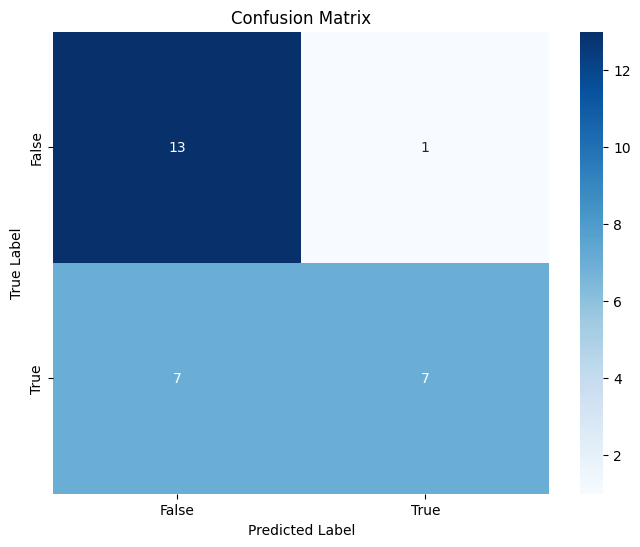

In [31]:

# Calculate metrics
f1 = f1_score(true_labels, predictions)
accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions)
recall = recall_score(true_labels, predictions)

print(f"F1 Score : {f1}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['False', 'True'], yticklabels=['False', 'True'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


2025-03-21 17:12:26.288529: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


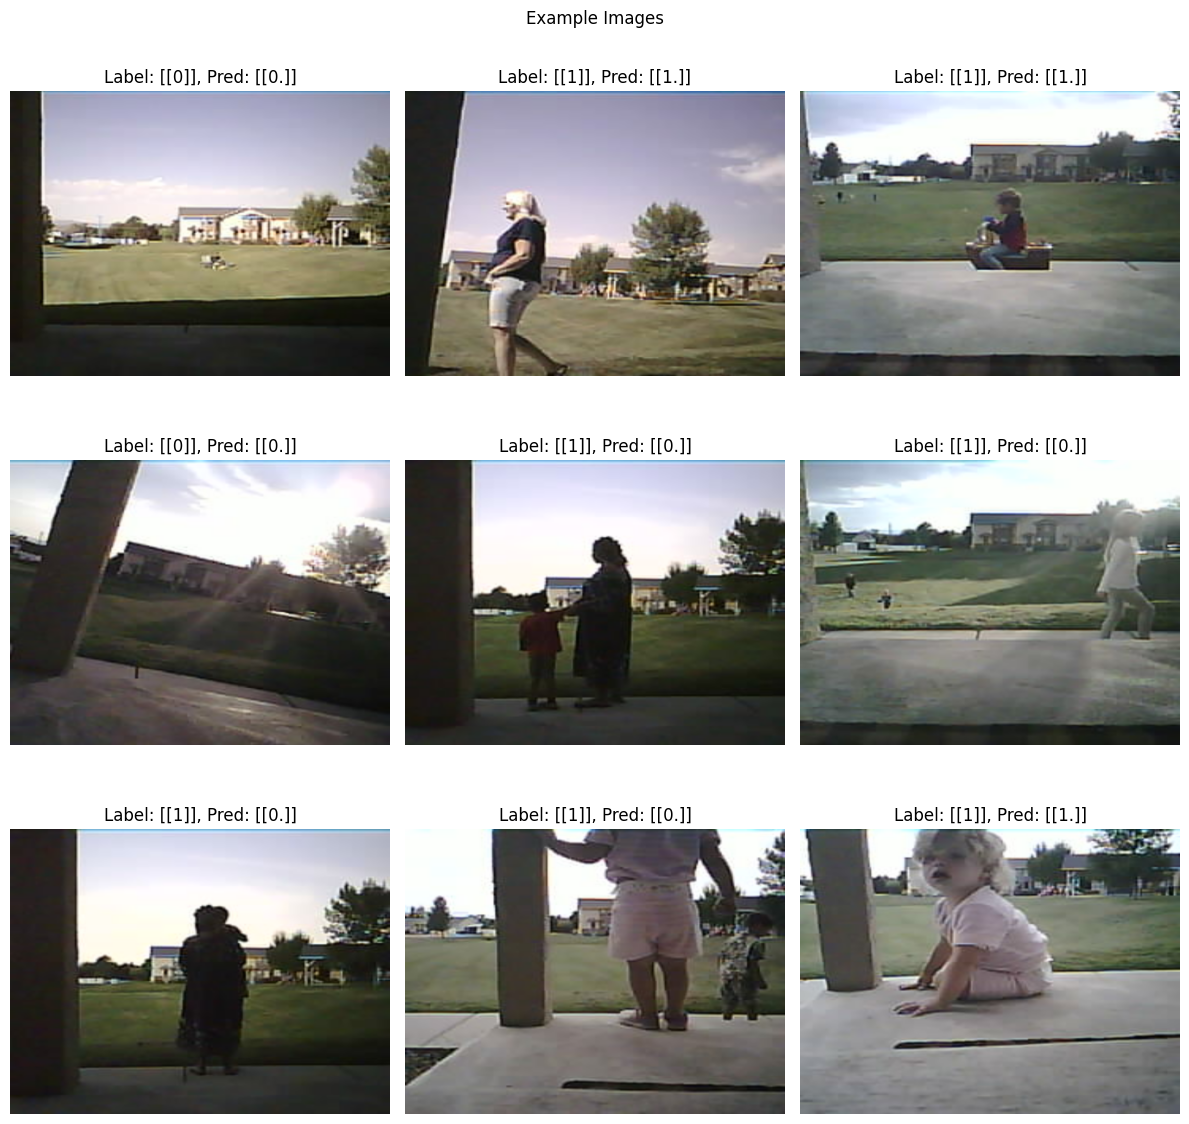

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


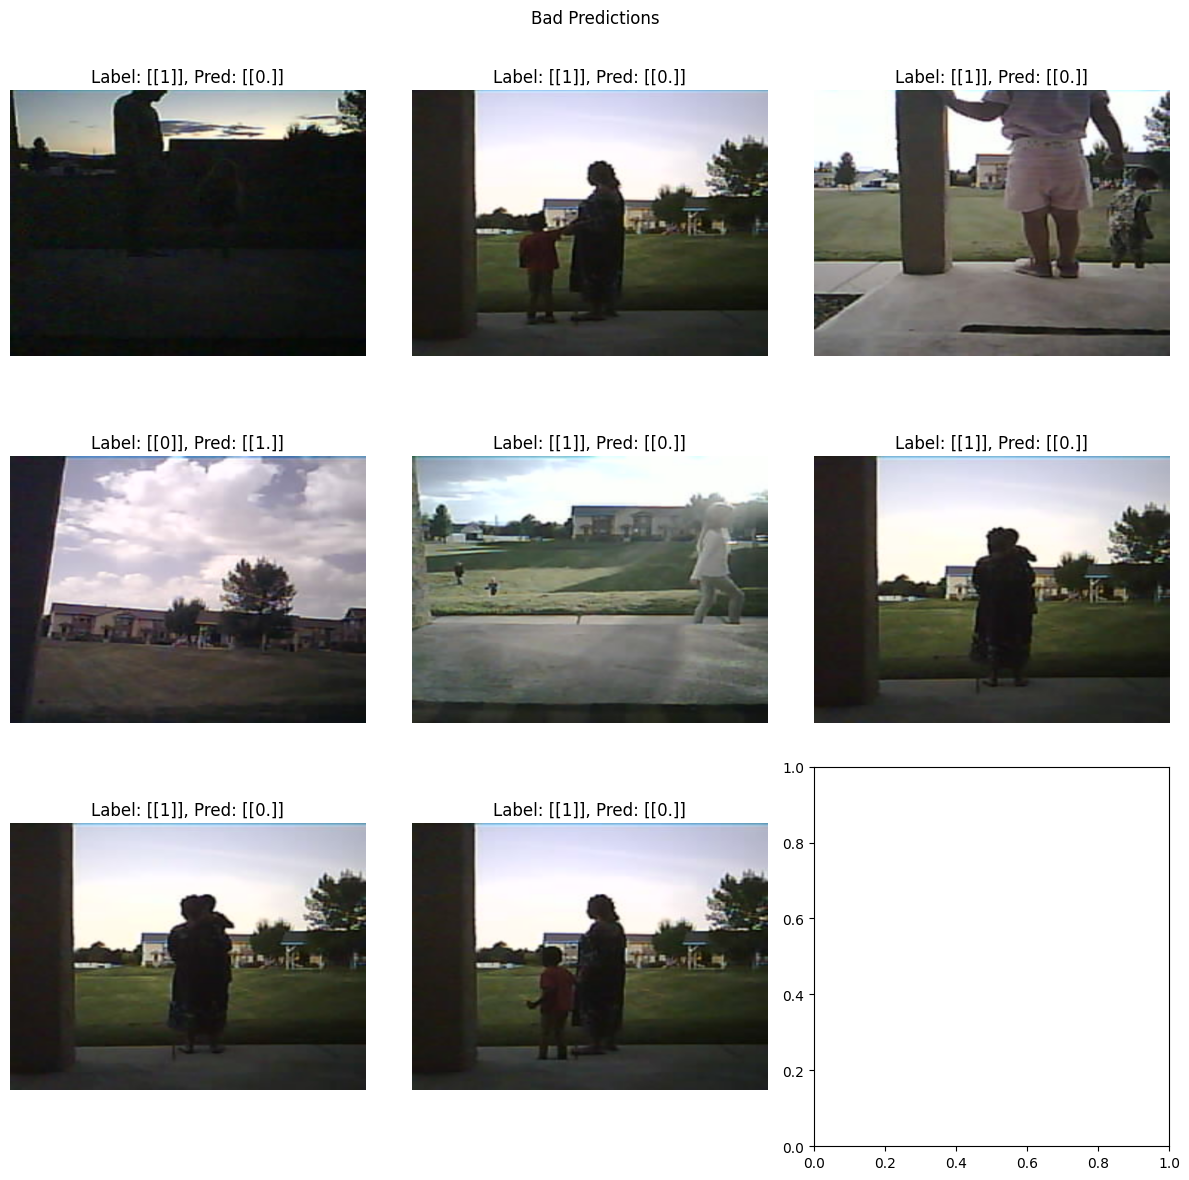

In [32]:

# show misclassified images
# for (image,label,prediction) in misclassified_images:
#     plt.title(f"True label: {label.numpy()}, Predicted label: {prediction}")
#     plt.imshow(tf.reshape(image, (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)))
#     plt.axis('off')
#     plt.show()
# Function to plot images in a grid
def plot_images_in_grid(ds, rows, cols, figsize, title):
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten()
    if hasattr(ds, 'take'):
     result = ds.take(rows * cols)
    else:
     result = ds[:rows * cols] 
    for i, example in enumerate(result):
        image = example[0]
        label = example[1]
        prediction = model.predict(image)
        

        
        axes[i].imshow(image.numpy().reshape( IMAGE_SHAPE))
        axes[i].set_title(f"Label: {label.numpy()}, Pred: {np.round(prediction)}")
        axes[i].axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()
plot_images_in_grid(balanced_validation_csv_dataset, 3, 3, (12, 12), "Example Images")
plot_images_in_grid(misclassified_images, 3, 3, (12, 12), "Bad Predictions")

# Optimizing Tensorflow for Microcontroller Deployment

## Quantize the model

### Create representative Data Set
The quantization process requires some example data.

In [33]:
REPRESENTATIVE_DATASET_SIZE = 100
def random_representative_data_gen():
  for _ in range(REPRESENTATIVE_DATASET_SIZE):
        yield [tf.random.uniform(shape=(1, *IMAGE_SHAPE), minval=0, maxval=1)]
def representative_data_gen():
  for (image,label) in ds_train.shuffle(REPRESENTATIVE_DATASET_SIZE).take(REPRESENTATIVE_DATASET_SIZE):
         yield [image]
  for (image,label) in balanced_train_csv_dataset.shuffle(REPRESENTATIVE_DATASET_SIZE).take(REPRESENTATIVE_DATASET_SIZE):
        yield [image]
  #yield random_representative_data_gen()
# random noise may work for some models 

  

### Configuring the converter for esp32

In [34]:
model = tf.keras.models.load_model(MODEL_SAVE_PATH)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.int8]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8
converter.inference_type = tf.int8
converter.inference_output_type =  tf.int8

tflite_model = converter.convert()
open(LITE_MODEL_SAVE_PATH, "wb").write(tflite_model)


INFO:tensorflow:Assets written to: /tmp/tmpuxd7rmwk/assets


INFO:tensorflow:Assets written to: /tmp/tmpuxd7rmwk/assets


Saved artifact at '/tmp/tmpuxd7rmwk'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 1440000), dtype=tf.float32, name='image')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  140242429587728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140242429581200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140242429578704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140242429581584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140242429584272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140242429588112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140242429580816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140242429582352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140242429581776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140242429580240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140242429579280: TensorSp

/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/convert.py:983: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
W0000 00:00:1742577152.406405      17 tf_tfl_flatbuffer_helpers.cc:392] Ignored output_format.
W0000 00:00:1742577152.406832      17 tf_tfl_flatbuffer_helpers.cc:395] Ignored drop_control_dependency.
2025-03-21 17:12:32.408757: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpuxd7rmwk
2025-03-21 17:12:32.415455: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-03-21 17:12:32.415478: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpuxd7rmwk
2025-03-21 17:12:32.480518: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2025-03-21 17:12:32.492461: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-03-21 17:1

620896

## Testing the ESP32 optimized model
Results from tf lite python should be similar to tf micro. Note the implementation for executing the models in both libraries is not the exact same.

### Loading a TFLite model in python

In [35]:
interpreter = tf.lite.Interpreter(model_path=LITE_MODEL_SAVE_PATH)
interpreter.allocate_tensors()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


### Check model inputs and outputs

In [36]:

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()


print(input_details)
print(output_details)
input_shape = input_details[0]['shape']
print(input_shape)
scale, zero_point = output_details[0]['quantization']
print(scale, zero_point)

[{'name': 'serving_default_image:0', 'index': 0, 'shape': array([      1, 1440000], dtype=int32), 'shape_signature': array([     -1, 1440000], dtype=int32), 'dtype': <class 'numpy.uint8'>, 'quantization': (0.003921568859368563, 0), 'quantization_parameters': {'scales': array([0.00392157], dtype=float32), 'zero_points': array([0], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
[{'name': 'StatefulPartitionedCall_1:0', 'index': 193, 'shape': array([1, 1], dtype=int32), 'shape_signature': array([-1,  1], dtype=int32), 'dtype': <class 'numpy.int8'>, 'quantization': (0.00390625, -128), 'quantization_parameters': {'scales': array([0.00390625], dtype=float32), 'zero_points': array([-128], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
[      1 1440000]
0.00390625 -128


### Test the model on data

Quantized model accuracy: 0.6428571428571429
Minimum result: 0.01171875
Maximum result: 0.99609375
Average result: 0.15248325892857142


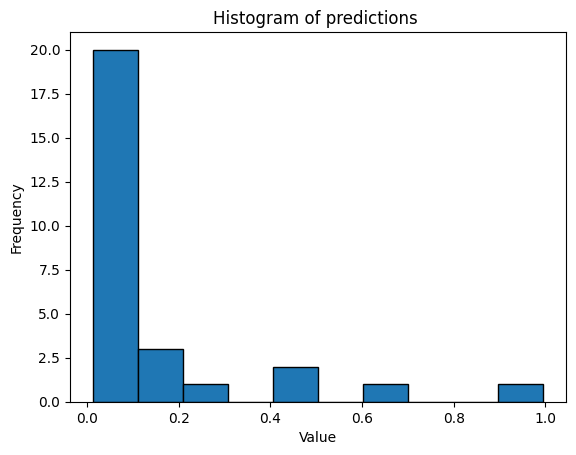

In [43]:
count=0
right_count=0
results=[]
for (image,label) in balanced_validation_csv_dataset.take(1000):
    uint8image=(tf.cast(image*255,tf.uint8))
    inputData=tf.reshape(uint8image,[1,MODEL_INPUT_SHAPE])
    interpreter.set_tensor(input_details[0]['index'],inputData )
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    count+=1
    result=  output_data[0][0]
    truth = label.numpy()[0][0]
    # print(f'pre scaled result: {result}')
    result = (result - zero_point) * scale
    results.append(result)

    # print(f'post scaled result: {result}')

    #print(result)
    # print(output_data)
    # print(truth)
    # print(label)
    # print('\n\n')

# since this we are testing on balanced validation dataset
# the threshold should be close to mean of the results that the model outputs
# the prediction is the probability of the image being a person
    prediction_threshold = 0.30

    if (result >= prediction_threshold) ==(label.numpy()[0][0]==1):
        right_count+=1

print(f'Quantized model accuracy: {right_count/count}')
#max and min

min_result = min(results)
max_result = max(results)
avg_result = sum(results)/len(results)
print(f'Minimum result: {min_result}')
print(f'Maximum result: {max_result}')
print(f'Average result: {avg_result}')

bin_width = (max_result - min_result)/10
bins = np.arange(min_result, max_result + bin_width,bin_width )

# Plot the histogram
plt.hist(results, bins=bins, edgecolor='black')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title(f'Histogram of predictions ')
plt.show()

## Create c/c++ files for the esp32

### Create C image files for validating the model on the esp32
Testing  firmware with these image will allows the ability tell if the model is performing the same way it did in python. without needing to validate your microontroller camera

- run tests with `pio test -vv -f "test_model_*"`

In [38]:
import os
# each test contains one image because we can only fit one full image in firmware at a time
for idx,(image, label) in enumerate(balanced_validation_csv_dataset.shuffle(1000).take(5)):
    uint8image = tf.cast(image * 255, tf.uint8) # Convert to numpy array
    # if folder for test does not exist create it
    test_folder = f'../test/test_model_{idx}'
    if not os.path.exists(test_folder):
        os.makedirs(test_folder)

    # Create the header and footer for the C/C++ array
    header = f'#pragma once \nunsigned char image_{idx}[] = {{\n'
    footer = f'\n}};\n\nunsigned char label_{idx} = ' + str(label.numpy()[0][0]) + ';' 

    # Save the image array to a text file with the specified header and footer
    np.savetxt(f'{test_folder}/image_{idx}.h', uint8image, fmt='%d', delimiter=',', header=header, footer=footer, comments='')
    # Save the image as a png so we can see what it is of
    cv2.imwrite(f'{test_folder}/image_{idx}.png', uint8image.numpy().reshape(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS))
    test = f"""
#include "Arduino.h"
#include <FS.h>
#include <WiFiClient.h>
#include <ConversionTools.h>
#include "esp_camera.h"
#include <Model.h>
#include <all_ops_resolver.h>
#include "image_{idx}.h"

#include "tensorflow/lite/micro/tflite_bridge/micro_error_reporter.h"
#include "tensorflow/lite/micro/micro_interpreter.h"
#include "tensorflow/lite/schema/schema_generated.h"

#include "unity.h"

unsigned char label = label_{idx};
unsigned char *image = image_{idx};
uint8_t *rawBuffer;
namespace
{{
    tflite::ErrorReporter *error_reporter = nullptr;
    const tflite::Model *model = nullptr;
    tflite::MicroInterpreter *interpreter = nullptr;
    TfLiteTensor *input = nullptr;
    // An area of memory to use for input, output, and intermediate arrays.
    const int kTensorArenaSize = 1024 * 1024;
    uint8_t *tensor_arena;
}}

void initTFInterpreter()
{{
    tensor_arena = (uint8_t *)ps_malloc(kTensorArenaSize);
    // TODO assert with unity that this init worked well
    static tflite::MicroErrorReporter micro_error_reporter;
    error_reporter = &micro_error_reporter;
    // Create Model
    model = tflite::GetModel(__model_tflite);
    // Verify Version of Tf Micro matches Model's verson
    if (model->version() != TFLITE_SCHEMA_VERSION)
    {{
        error_reporter->Report(
            "Model provided is schema version %d not equal "
            "to supported version %d.",
            model->version(), TFLITE_SCHEMA_VERSION);
        return;
    }}
    CREATE_ALL_OPS_RESOLVER(op_resolver)
    // Build an interpreter to run the model with.
    static tflite::MicroInterpreter static_interpreter(
        model, op_resolver, tensor_arena, kTensorArenaSize);
    interpreter = &static_interpreter;

    // Allocate memory from the tensor_arena for the model's tensors.
    TfLiteStatus allocate_status = interpreter->AllocateTensors();
    if (allocate_status != kTfLiteOk)
    {{
        error_reporter->Report("AllocateTensors() failed");
        return;
    }}

    // Get information about the memory area to use for the model's input.
    input = interpreter->input(0);
    error_reporter->Report("Input Shape");
    for (int i = 0; i < input->dims->size; i++)
    {{
        error_reporter->Report("%d", input->dims->data[i]);
    }}

    error_reporter->Report(TfLiteTypeGetName(input->type));
    error_reporter->Report("Output Shape");

    TfLiteTensor *output = interpreter->output(0);
    for (int i = 0; i < output->dims->size; i++)
    {{
        error_reporter->Report("%d", output->dims->data[i]);
    }}
    error_reporter->Report(TfLiteTypeGetName(output->type));
    error_reporter->Report("Arena Used:%d bytes of memory", interpreter->arena_used_bytes());
}}
void setUp(void)
{{
    // set stuff up here
}}

void tearDown(void)
{{
    // clean stuff up here
}}

void test_model(void)
{{
    initTFInterpreter();
    uint raw_image_size = 240 * 240 * 3;

    memcpy(input->data.uint8, image, raw_image_size);

    int start = millis();
    error_reporter->Report("Invoking.");

    if (kTfLiteOk != interpreter->Invoke()) // Any error i have in invoke tend to just crash the whole system so i dont usually see this message
    {{
        error_reporter->Report("Invoke failed.");
    }}
    else
    {{
        error_reporter->Report("Invoke passed.");
        error_reporter->Report(" Took : %d milliseconds", millis() - start);
    }}

    TfLiteTensor *output = interpreter->output(0);
    int result = output->data.int8[0];
    float result_float = (result - model_quantization_zero_point) * model_quantization_scale;
    error_reporter->Report("Float result: %f", result_float);
    bool person = result_float > default_model_prediction_threshold;
    bool truth = label == 1;
    error_reporter->Report("predicted %d truth %d", person, truth);

    TEST_ASSERT_EQUAL_UINT(truth, person);
}}

int runUnityTests(void)
{{
    UNITY_BEGIN();
    RUN_TEST(test_model);
    return UNITY_END();
}}

void setup()
{{
    // Wait ~2 seconds before the Unity test runner
    // establishes connection with a board Serial interface
    delay(2000);

    runUnityTests();
}}
void loop() {{}}

"""
    with open(f'{test_folder}/test_model_{idx}.cpp', 'w') as f:
        f.write(test)
